In [1]:
import perceval as pcvl
import perceval.components as comp
from perceval.algorithm import Sampler

from qlass.helper_functions import loss_function, rotate_qubits
from qlass.hamiltonians import LiH_hamiltonian, LiH_hamiltonian_tapered
from qlass.classical_solution import brute_force_minimize

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

from scipy.optimize import minimize
from tqdm import tqdm
import matplotlib.pyplot as plt

## Photonic VQE simulations using a parametrized unitary or Qiskit circuits

In the following cell we define a function that generates arbitrary two qubit unitaries given the parameters. This can be used in a VQE simulation to find ground states of two qubit Hamiltonians.
One can also use a custom function that generates a unitary according to some custom noise model.

In [2]:
import numpy as np
from scipy.linalg import expm
import numpy as np
from scipy.linalg import sqrtm

# Pauli matrices and identity
sigma_0 = np.eye(2, dtype=complex)  # Identity matrix
sigma_1 = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_2 = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_3 = np.array([[1, 0], [0, -1]], dtype=complex)

# List of Pauli matrices (including identity)
paulis = [sigma_0, sigma_1, sigma_2, sigma_3]

def construct_unitary_from_parameters(params):
    """
    Constructs a 4x4 unitary matrix from 16 real parameters using the basis Γ(i, j) = σ_i ⊗ σ_j.

    Args:
        params (list or np.ndarray): A list or array of 16 real parameters.

    Returns:
        np.ndarray: A 4x4 unitary matrix.
    """
    if len(params) != 16:
        raise ValueError(f"Exactly 16 parameters are required, but {len(params)} were given.")
    
    # Reshape the parameters into a 4x4 grid for easier indexing
    params_grid = np.array(params).reshape(4, 4)
    
    # Initialize the 4x4 Hermitian matrix
    H = np.zeros((4, 4), dtype=complex)
    
    # Construct the Hermitian matrix H = sum_{i,j} d(i,j) Γ(i,j)
    for i in range(4):
        for j in range(4):
            # Compute Γ(i,j) = σ_i ⊗ σ_j
            gamma_ij = np.kron(paulis[i], paulis[j])
            # Add the term d(i,j) * Γ(i,j) to H
            H += params_grid[i, j] * gamma_ij
    
    # Construct the unitary matrix U = exp(iH)
    U = expm(1j * H)
    
    return U

def check_unitarity(U, tolerance=1e-10):
    """Check if a matrix is unitary within given tolerance"""
    I = np.eye(U.shape[0], dtype=U.dtype)
    UHU = U.conj().T @ U
    max_diff = np.max(np.abs(UHU - I))
    return max_diff, max_diff < tolerance

U = construct_unitary_from_parameters(np.random.rand(16))
check_unitarity(U)

(np.float64(4.644914445067638e-16), np.True_)

We use executors to obtain samples from eiter a quantum simulator of quantum hardware, just like how we use executors in Mitiq. This makes things considerably more modular.

In [3]:
# Mach-Zehnder interferometer
mzi = comp.BS() // (0, comp.PS(pcvl.Parameter("phi1"))) // comp.BS() // (0, comp.PS(pcvl.Parameter("phi2")))

#Executor for a two qubit unitary.
def executor(lp, pauli_string):

    params = np.concatenate((np.random.rand(11), lp))
    num_qubits = len(pauli_string)

    unitary = construct_unitary_from_parameters(params)
    M = pcvl.Matrix(unitary)
    ansatz = pcvl.Circuit.decomposition(M, mzi, shape=pcvl.InterferometerShape.TRIANGLE)
    ansatz_rot = rotate_qubits(pauli_string, ansatz.copy())
    processor = pcvl.Processor(pcvl.NaiveBackend(), ansatz_rot)
    
    processor.with_input(pcvl.BasicState([0,1]*num_qubits))

    sampler = Sampler(processor)
    samples = sampler.samples(10_000)

    return samples
executor(np.random.rand(5), 'II')['results'][:10]

[|0,1,0,1>,
 |0,0,2,0>,
 |0,1,0,1>,
 |0,1,1,0>,
 |0,1,0,1>,
 |0,1,1,0>,
 |0,1,0,1>,
 |0,1,1,0>,
 |0,1,0,1>,
 |2,0,0,0>]

In the following cell, we have a few Hamiltonians from the LiH molecule that we can use to simulate our VQE.

In [4]:
R = [0.1+i*0.1 for i in range(30)]
hamiltonians = [LiH_hamiltonian(R=r, num_electrons=2, num_orbitals=1) for r in R]

We can now start the VQE simulation

In [5]:
radius1 = []
E1 = []


for i in tqdm(range(len(R))):  # We try to find the ground state eigenvalue for each radius R

    H = hamiltonians[i]
    radius1.append(R[i])
    
    initial_params = np.random.rand(5)

    # Finding the ground state eigen value for each H(R)
    result = minimize(loss_function, initial_params, args=(H, executor), method='COBYLA', options={'maxiter': 20})
    # print(f'number of function evaluations: {result.nfev}')
    E1.append(result.get('fun'))


100%|██████████| 30/30 [04:12<00:00,  8.41s/it]


In [6]:
E1_th = [brute_force_minimize(H) for H in hamiltonians]

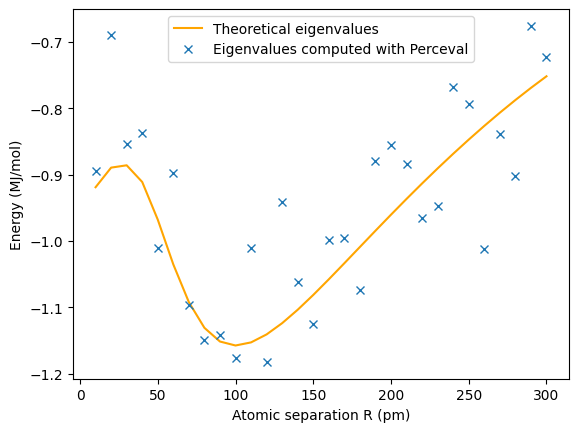

The minimum energy is E_g(1.2000000000000002)=-1.1823213141645204 MJ/mol and is attained for R_min =1.2000000000000002 pm


In [7]:
plt.plot(100*np.array(radius1), np.array(E1_th),'orange')
plt.plot(100*np.array(radius1), E1,'x')
plt.ylabel('Energy (MJ/mol)')
plt.xlabel('Atomic separation R (pm)')

plt.legend(['Theoretical eigenvalues', 'Eigenvalues computed with Perceval'])

plt.show()

min_value=min(E1)
min_index = E1.index(min_value)
print('The minimum energy is E_g('+str(radius1[min_index])+')='+str(E1[min_index])+' MJ/mol and is attained for R_min ='+str(radius1[min_index])+' pm')

This is the VQE simulation but now we use Qiskit circuits instead.

In [8]:
from perceval.converters import QiskitConverter
from qiskit import transpile
from qiskit.circuit.library import TwoLocal

qiskit_converter = QiskitConverter(backend_name="Naive") #or SLOS

#Executor for a two qubit qiskit ansatz.
def executor(lp, pauli_string):

    num_qubits = len(pauli_string)
    ansatz = TwoLocal(num_qubits, 'ry', 'cx', reps=1)

    ansatz_assigned = ansatz.assign_parameters(lp)
    ansatz_assigned = transpile(ansatz_assigned, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)

    ansatz_rot = rotate_qubits(pauli_string, ansatz_assigned.copy())
    processor = qiskit_converter.convert(ansatz_rot, use_postselection=True)  
    processor.with_input(pcvl.LogicalState([0]*num_qubits))

    sampler = Sampler(processor)
    samples = sampler.samples(10_000)

    return samples

In [9]:
radius1 = []
E1_qiskit = []

num_qubits = 2

for i in tqdm(range(len(R))):  # We try to find the ground state eigenvalue for each radius R

    H = hamiltonians[i]
    radius1.append(R[i])
    
    initial_params = np.random.rand(2*num_qubits)

    # Finding the ground state eigen value for each H(R)
    result = minimize(loss_function, initial_params, args=(H, executor), method='COBYLA', options={'maxiter': 30})
    # print(f'number of function evaluations: {result.nfev}')
    E1_qiskit.append(result.get('fun'))

100%|██████████| 30/30 [06:44<00:00, 13.47s/it]


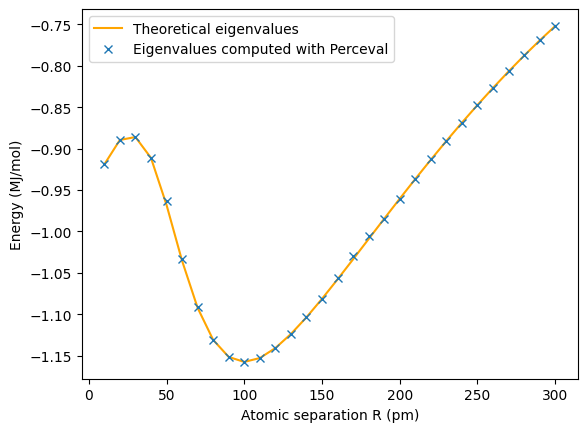

The minimum energy is E_g(1.0)=-1.1575370975412058 MJ/mol and is attained for R_min =1.0 pm


In [10]:
plt.plot(100*np.array(radius1), np.array(E1_th),'orange')
plt.plot(100*np.array(radius1), E1_qiskit,'x')
plt.ylabel('Energy (MJ/mol)')
plt.xlabel('Atomic separation R (pm)')

plt.legend(['Theoretical eigenvalues', 'Eigenvalues computed with Perceval'])

plt.show()

min_value=min(E1_qiskit)
min_index = E1_qiskit.index(min_value)
print('The minimum energy is E_g('+str(radius1[min_index])+')='+str(E1_qiskit[min_index])+' MJ/mol and is attained for R_min ='+str(radius1[min_index])+' pm')